Generate a bone-scaling dataset

In [64]:
%load_ext autoreload
%autoreload 3 --print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kpsn_test.routines.datasets import npy_keypts
from kpsn_test.routines.datasets import blscale
from kpsn_test.routines.util import update
from kpsn_test import visualize as viz
from kpsn.util import keypt_io

from mph.data_explore.lib.morphs import linear_skeletal as ls
from mph.data_explore.lib import skeleton

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/bonescale_dataset'

### Manually adjust

In [131]:
default_tree = skeleton.Armature(keypt_io.keypt_names, skeleton.bones, 'shldr')
hip_tree = skeleton.reroot(default_tree, 'hips')
# hip_tree = default_tree
skel = ls.construct_transform(hip_tree, hip_tree.keypt_by_name['hips'])

Reloading 'kpsn.models.morph.linear_skeletal'.


[autoreload of kpsn.models.morph.linear_skeletal failed: Traceback (most recent call last):
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 305, in update_function
    setattr(old, name, getattr(new, name))
ValueError: wrapped() requires a code object with 1 free vars, not 0
]


In [132]:
(N, M), gt_obs, metadata = npy_keypts.generate(
    cfg = update(npy_keypts.defaults, dict(
        path = '../../../data_explore/data',
        rescale = False,
        age_blacklist = [9, 12]
)))
slices = metadata['session_slice']

all_roots, all_bones = ls.transform(gt_obs.keypts.reshape([-1, 14, 3]), skel)
all_lengths = np.linalg.norm(all_bones, axis = -1)

ages, age_groups = keypt_io.get_groups_dict(metadata['age'])
sess_lengths = {
    sess_name: np.mean(all_lengths[slc], axis = 0)
    for sess_name, slc in slices.items()}
age_lengths = {
    age: np.mean([sess_lengths[s] for s in age_group], axis = 0)
    for age, age_group in zip(ages, age_groups)}

In [100]:
remap_bones = {}
remap_metadata = {}
remap_lengths = {}
src_sessions = [age_groups[i][0] for i in [0]] # or [0, 1, 3, 5]

for src_sess in slices:
    slc = slices[src_sess]
    bones = {src_sess: all_bones[slc]}
    meta = {f'src-{k}': {src_sess: metadata[k][src_sess]} for k in metadata}
    src_age = metadata['age'][src_sess]
    meta['tgt_age'] = {src_sess: src_age}
    
    for tgt_age in ages:
        if tgt_age == src_age: pass

        new_sess = f'{tgt_age}wk_m{metadata["id"][src_sess]}'
        length_ratios = age_lengths[tgt_age] / age_lengths[src_age]
        bones[new_sess] = all_bones[slc] * length_ratios[None, :, None]
        for k in metadata:
            meta[f'src-{k}'][new_sess] = metadata[k][src_sess]
        meta['tgt_age'][new_sess] = tgt_age

    slcs, all_bn = keypt_io.to_flat_array(bones)
    remap_bones[src_sess] = all_bn
    remap_lengths[src_sess] = np.linalg.norm(all_bn, axis = -1)
    meta['session_slice'] = slcs
    remap_metadata[src_sess] = meta

### Load with routine

In [136]:

src_sessions = [age_groups[i][0] for i in [0]] # or [0, 1, 3, 5]
remap_metadata = {}
remap_obs = {}
remap_lengths = {}
for src_sess in src_sessions:
    _, obs, meta = blscale.generate(update(blscale.defaults, dict(
        src_sess = src_sess,
        path = '../../../data_explore/data',
        age_blacklist = [9, 12]
    )))

    remap_obs[src_sess] = obs
    remap_metadata[src_sess] = meta
    remap_roots, remap_bones = ls.transform(
        obs.keypts.reshape([-1, hip_tree.n_kpts, 3]), skel)
    remap_lengths[src_sess] = np.linalg.norm(remap_bones, axis = -1)

(215526, 3) (215526, 13, 3)
(14, 14) (215526, 14, 3) (215526, 3)


### Validate results

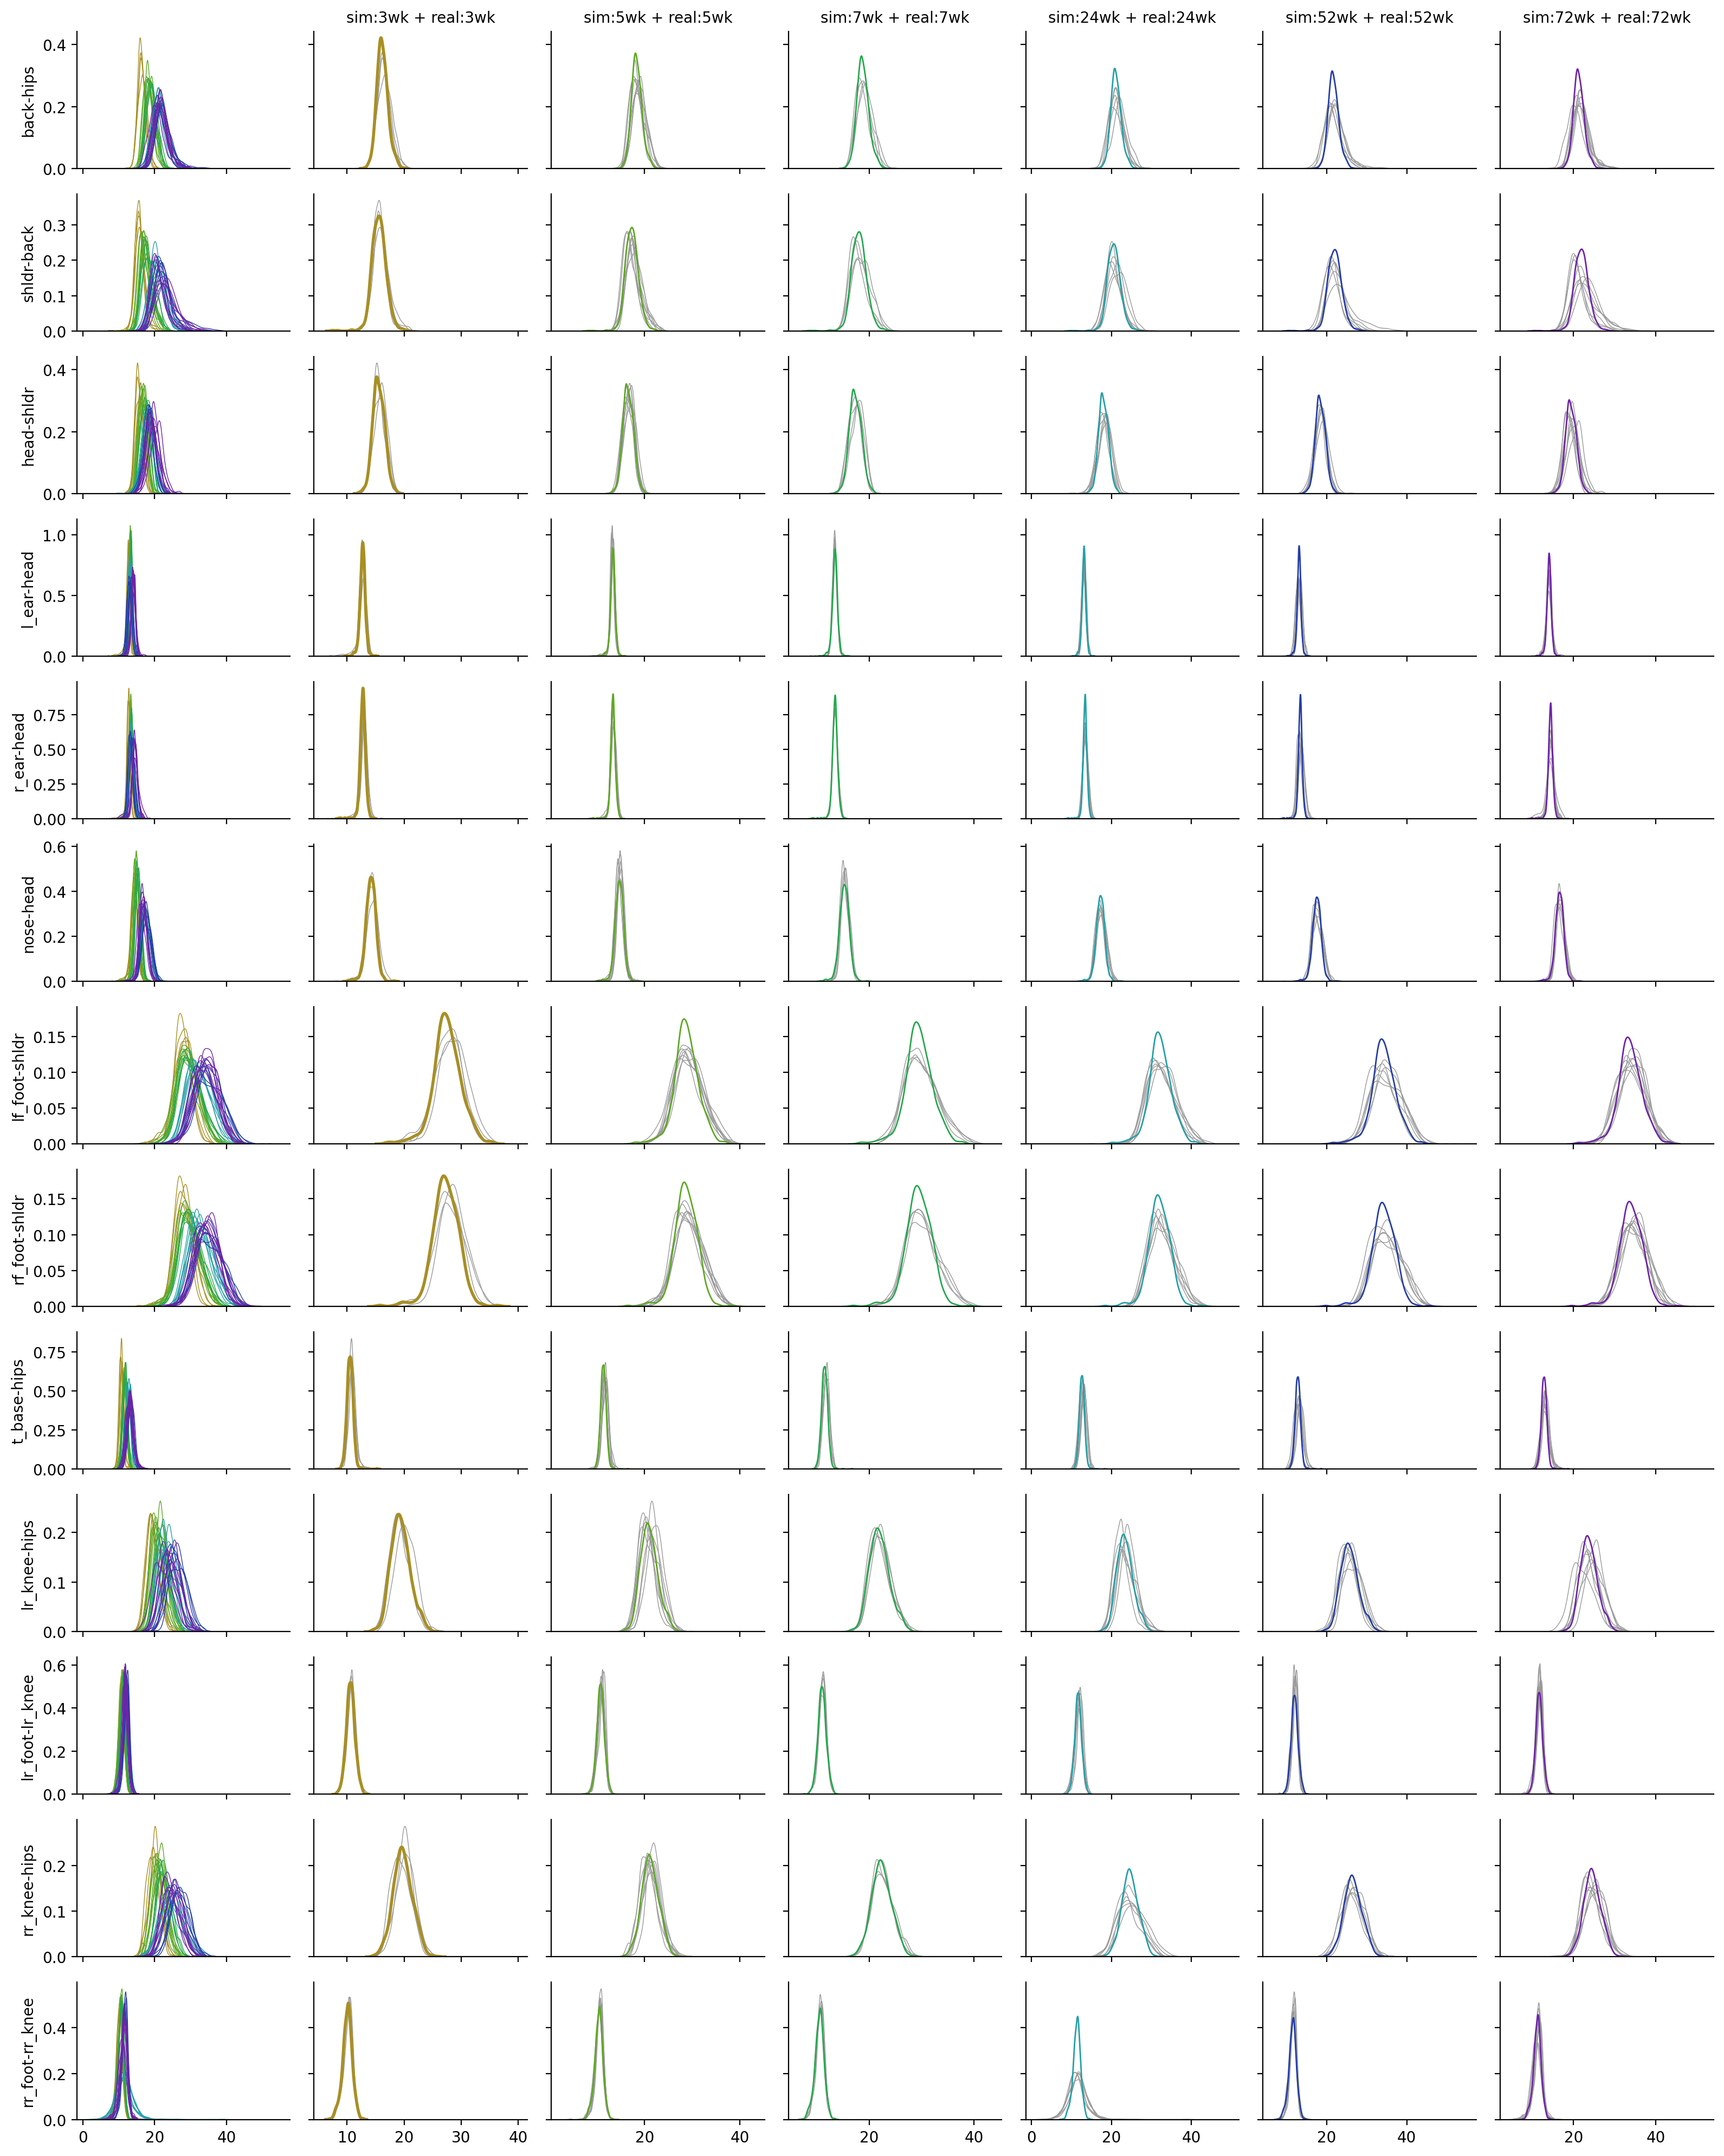

In [66]:
fig, ax = plt.subplots(figsize = (16, 20),
    nrows = all_bones.shape[-2],
    ncols = 1 + len(ages),
    sharex = 'col', sharey = 'row')
age_pal = viz.defaults.age_pal(metadata['age'])
src_sess = '3wk_m0'

subsample = 50
for i_bone in range(len(skeleton.bones)):
    for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
        for i_mouse, sess_name in enumerate(age_group):
            sns.kdeplot(
                all_lengths[slices[sess_name]][::subsample, i_bone],
                ax = ax[i_bone, 0],
                color = age_pal[age],
                lw = 0.5,
                label = age if i_mouse == 0 else None)
            
            col = i_age + 1
            sns.kdeplot(
                all_lengths[slices[sess_name]][::subsample, i_bone],
                ax = ax[i_bone, col],
                color = '.6',
                lw = 0.5,
                label = age if i_mouse == 0 else None)
    ax[i_bone, 0].set_ylabel(hip_tree.bone_name(i_bone))

    tgt_ages, tgt_age_groups = keypt_io.get_groups_dict(
        remap_metadata[src_sess]['tgt_age'])
    
    for i_tgt_age, (tgt_age, tgt_age_group) in enumerate(zip(tgt_ages, tgt_age_groups)):
        col = i_tgt_age + 1
        for i_tgt_sess, tgt_sess in enumerate(tgt_age_group):
            is_source = tgt_age == metadata['age'][src_sess]
            slc = remap_metadata[src_sess]['session_slice'][tgt_sess]
            sns.kdeplot(
                    remap_lengths[src_sess][slc][::subsample, i_bone],
                    ax = ax[i_bone, col],
                    color = age_pal[tgt_age],
                    lw = 2 if is_source else 1,
                    # ls = '-' if is_source else '--',
                    label = tgt_age if i_tgt_sess == 0 else None)
        ax[0, col].set_title(f"sim:{tgt_age}wk + real:{tgt_age}wk", fontsize = 10)

sns.despine()
plt.tight_layout()
plt.savefig(f"{plot_dir}/singlesubj-validation.png", dpi = 300)
plt.show()

Reloading 'kpsn.models.morph.linear_skeletal'.


[autoreload of kpsn.models.morph.linear_skeletal failed: Traceback (most recent call last):
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/Users/kaifox/projects/mph/mph/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 305, in update_function
    setattr(old, name, getattr(new, name))
ValueError: wrapped() requires a code object with 1 free vars, not 0
]


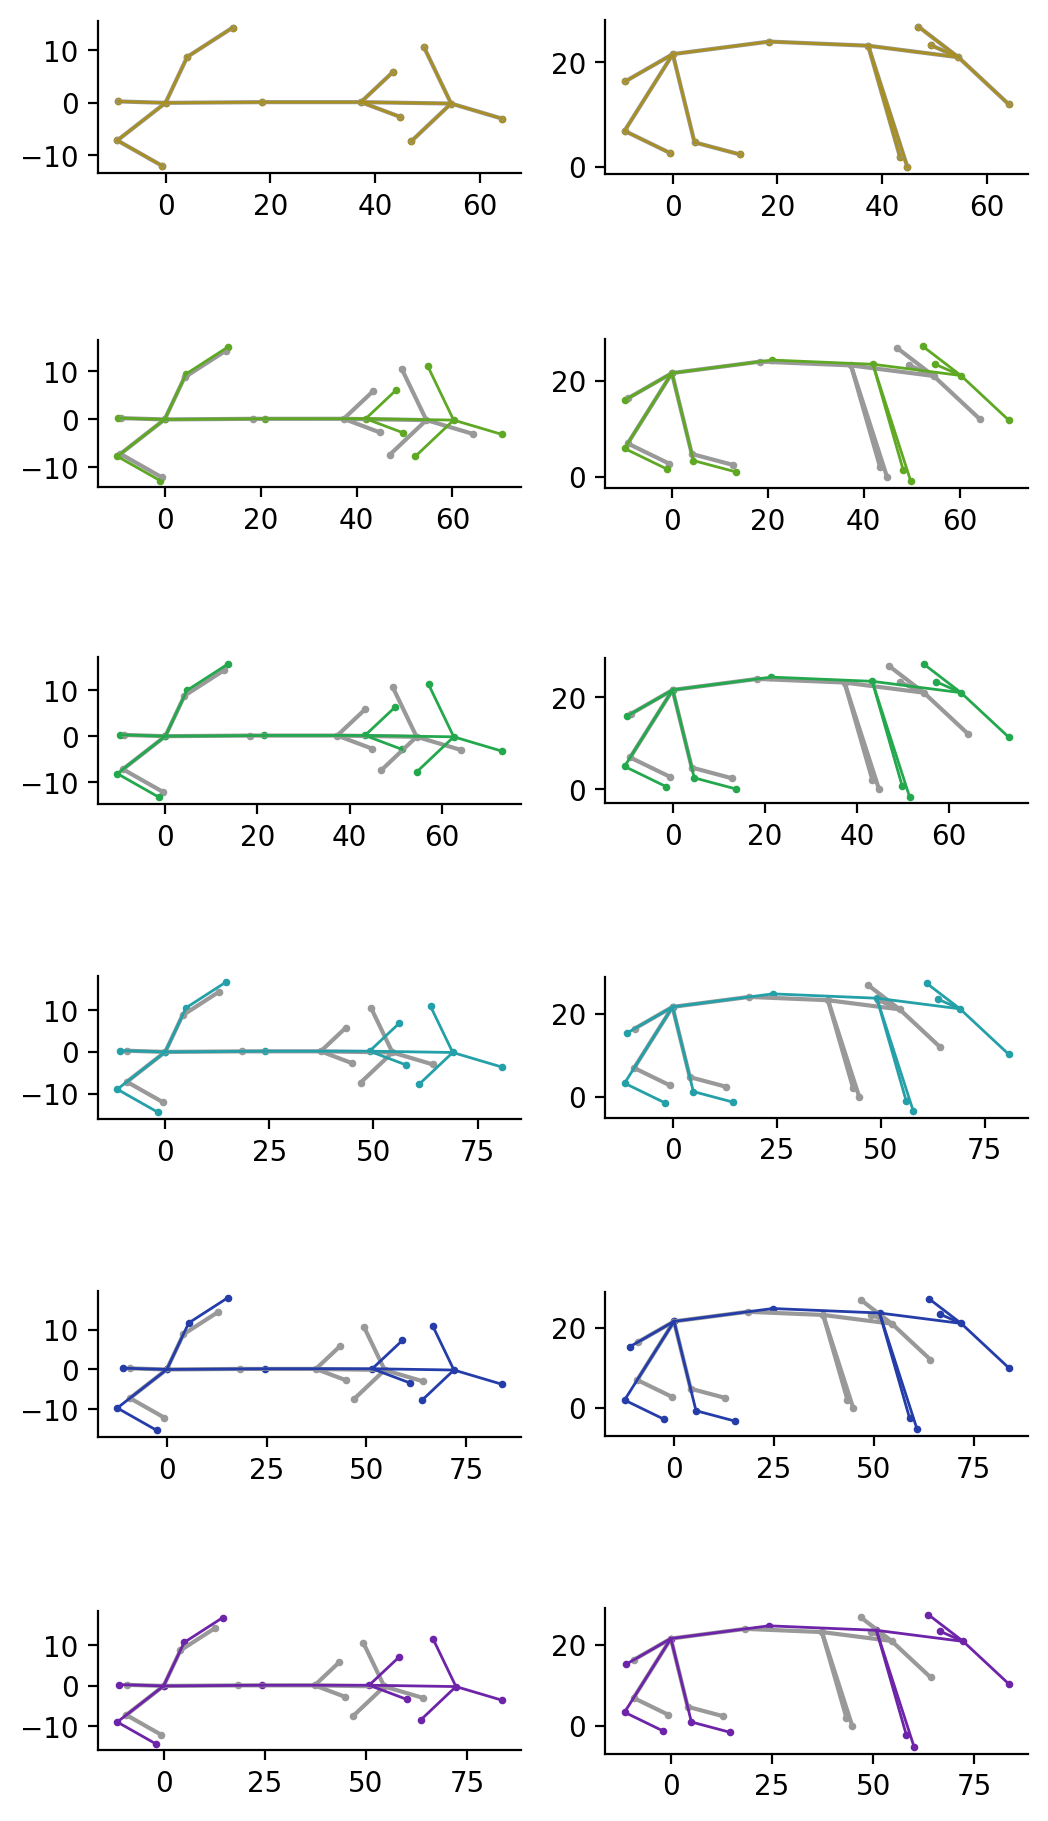

In [137]:
frame = 200
src_sess = '3wk_m0'
meta = remap_metadata[src_sess]

tgt_ages, tgt_age_groups = keypt_io.get_groups_dict(meta['tgt_age'])

fig, ax = plt.subplots(nrows = len(meta['tgt_age']), ncols = 2, figsize = (6, 12))

for i_tgt_age, (tgt_age, tgt_age_group) in enumerate(zip(tgt_ages, tgt_age_groups)):
    tgt_sess = tgt_age_group[0]
    tgt_slc = meta['session_slice'][tgt_sess]
    src_slc = meta['session_slice'][src_sess]
    for col, xaxis, yaxis in [(0, 0, 1), (1, 0, 2)]:
        viz.diagram_plots.plot_mouse(
            ax[i_tgt_age, col],
            remap_obs[src_sess].keypts[src_slc][frame].reshape([14, 3]),
            xaxis, yaxis,
            scatter_kw = {'color': '.6'},
            line_kw = {'color': '.6'})
        viz.diagram_plots.plot_mouse(
            ax[i_tgt_age, col],
            remap_obs[src_sess].keypts[tgt_slc][frame],
            xaxis, yaxis,
            scatter_kw = {'color': age_pal[tgt_age]},
            line_kw = {'color': age_pal[tgt_age], 'lw': 1})

sns.despine()
plt.show()